In [28]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import pairwise_distances
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import kurtosis, skew

random_state = 10 # Ensure reproducible results
%matplotlib inline

In [29]:
#------------DATA and TRAIN VALIDATION TEST SPLIT-----------------
#--- load data
ing_mat = loadmat('MATLAB/ingredients.mat')['ingredients']
cityDist_mat = loadmat('MATLAB/citiesDistMat.mat')['citiesDistMat']
labelName_mat = loadmat('MATLAB/labelNames.mat')['labelNames']
labels_mat = loadmat('MATLAB/labels.mat')['labels']
recipe_mat = loadmat('MATLAB/recipes.mat')['recipes']

#--- for colnames
ing_headline = []
for i in ing_mat[0]:
    ing_headline.append(i[0])

#--- create data matrices
dataset_X = pd.DataFrame(recipe_mat,columns=ing_headline) #predictors
dataset_y = pd.DataFrame(labels_mat,columns=['label']) #labels
X_train_full,X_test,y_train_full,y_test = train_test_split(dataset_X,dataset_y,test_size=0.2, random_state=10) #train test split
X_train,X_val,y_train,y_val = train_test_split(X_train_full,y_train_full,test_size=0.25, random_state=10) #train val split
X_train_len = len(X_train)


In [30]:
dataset_y = dataset_y.squeeze()
y_train = y_train.squeeze()

In [31]:
#--- additionally have cuisines as list
cuisines = []
for n in range(0, 12, 1):
    idx = dataset_y.index[dataset_y.values == n+1]
    cuisines.append(labelName_mat[idx[0]][0].item())

# Exploratory Data Analysis

## Plots

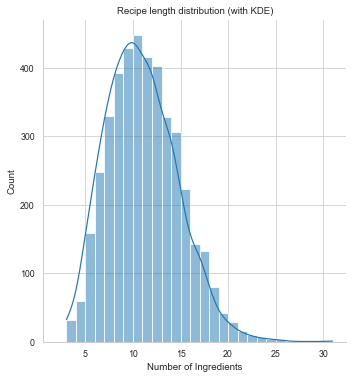

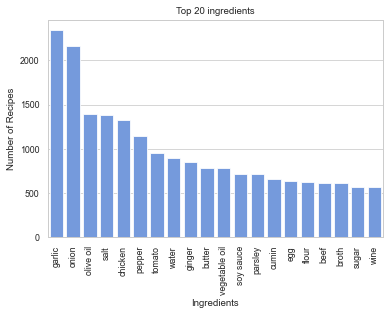

In [75]:
#------------EXPLORATORY DATA ANALYSIS-----------------

## Diagrams
## -- Plot number of ingredients
sns.set_context('paper')
sns.set_style("whitegrid")
ax = sns.displot(np.sum(dataset_X,axis=1), bins=np.linspace(1,29,29)+1,kde=True)
ax.set(xlabel="Number of Ingredients", title="Recipe length distribution (with KDE)")
ax.savefig("./Figures/Recipe_length.png", dpi=500) ## Save the figure produced

##--- top 20 most used ingredients
fig, ax = plt.subplots()
# sum up occurences of each ingredient and
# filter for the 20 most frequent
most_freq_ing = dataset_X.sum().nlargest(20)
ax = sns.barplot(x=most_freq_ing.index, y=most_freq_ing.values, color='cornflowerblue')
ax.set(xlabel="Ingredients", ylabel="Number of Recipes", title="Top 20 ingredients")
xticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.figure.savefig("./Figures/Top_20.png", dpi=500,bbox_inches='tight') ## Save the figure produced

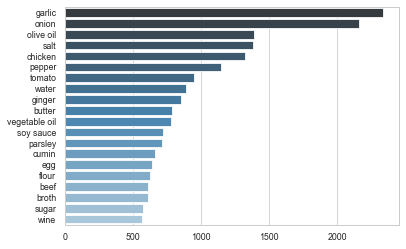

In [74]:
## 2nd Version of barplot, with vertical orientation
cc = sns.color_palette("Blues_d", 20)
ax = sns.barplot(y=most_freq_ing.index,x=most_freq_ing.values, palette=reversed(cc))
ax.figure.savefig("./Figures/Top_20.png", dpi=500,bbox_inches='tight') ## Save the figure produced

In [67]:
## --- Metrics for the recipe length distribution
print("recipe length median {}".format(np.sum(dataset_X,axis=1).median()))
print("recipe length mean {}".format(round(np.sum(dataset_X,axis=1).mean(),4)))
print("recipe length max {}".format(np.sum(dataset_X,axis=1).max()))
print("recipe length min {}".format(np.sum(dataset_X,axis=1).min()))
print("recipe length Kurtosis {}".format(round(kurtosis(np.sum(dataset_X,axis=1)),4)))
print("recipe length skewness {}".format(round(skew(np.sum(dataset_X,axis=1)),4)))

recipe length median 11.0
recipe length mean 10.8388
recipe length max 31
recipe length min 3
recipe length Kurtosis 0.1946
recipe length skewness 0.4581


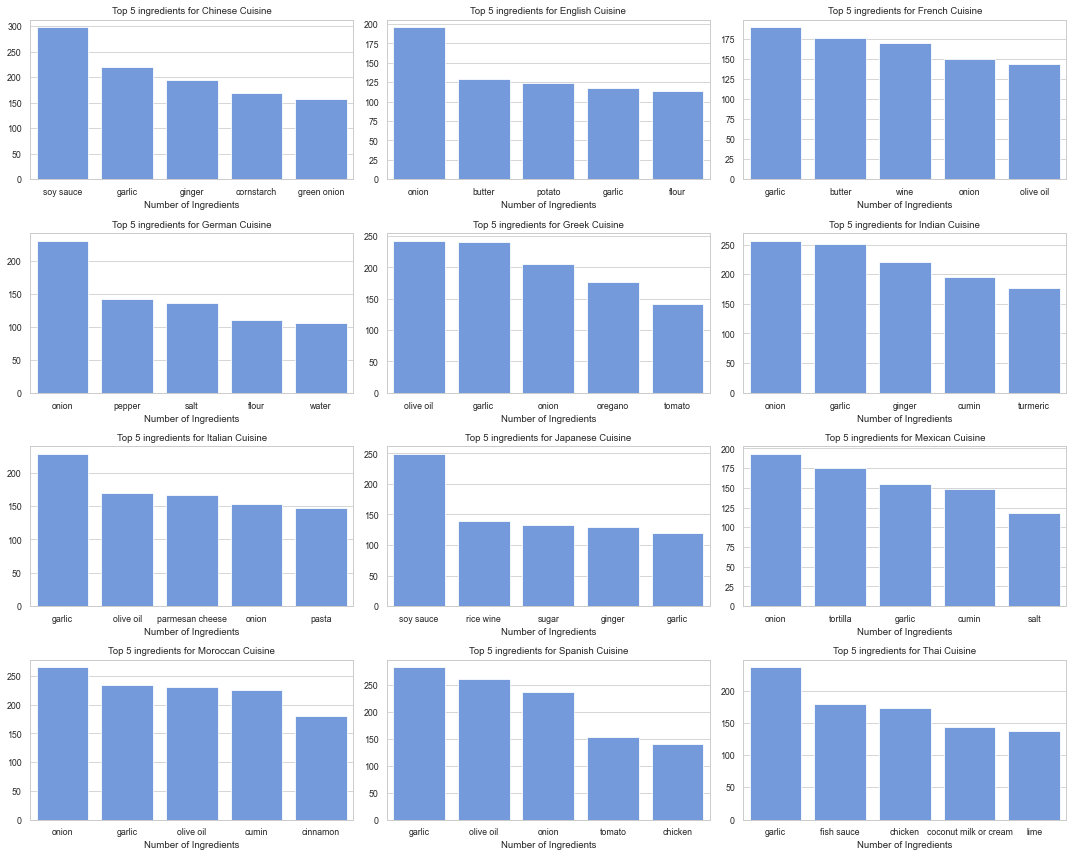

In [73]:
## Top ingredients per Cuisine

n_ing = 5

fig, axes = plt.subplots(4,3, figsize=(15,12))
n = 0
for i in range(0,4,1):
    for j in range(0,3,1):
        n+=1
        idx = dataset_y.index[dataset_y.values == n]
        freq_ing_cuis = dataset_X.loc[idx].sum()
        most_freq_ing_cuis = freq_ing_cuis.nlargest(n_ing)
        ax = sns.barplot(x=most_freq_ing_cuis.index, y=most_freq_ing_cuis, ax=axes[i,j], color='cornflowerblue')
        ax.set(xlabel="Number of Ingredients", title="Top 5 ingredients for {} Cuisine".format(labelName_mat[idx[0]][0].item()))
        plt.tight_layout()

        
# ax.figure.savefig("./Figures/top_ing_per_cuisine.png", dpi=500,bbox_inches='tight') ## Save the figure produced

## Tables

### Number of ingredients per cuisine

In [70]:
## Tables
## number changes due to the randomness of the split...
used_ing = []
for n in range(0, 12, 1):
    idx = dataset_y.index[dataset_y.values == n+1] # find number of recipes per label // due to .squeeze() changed from .label to .values
    freq_ing_cuis = dataset_X.loc[idx].sum() # find ingredients in the recipes per label
    used_idx = freq_ing_cuis.index[freq_ing_cuis != 0] 
    used_ing.append(len(used_idx)) # append total ingredients

data_ing = pd.DataFrame(data = {"Cuisine": cuisines, 
                                "#Ingredients Used": used_ing})

data_ing.sort_values(by="#Ingredients Used", ascending=False)

## might be better to use original dataset as follows:

# used_ing = []
# for n in range(0, 12, 1):
#     idx = dataset_y.index[dataset_y.values == n+1] // due to .squeeze() changed from .label to .values
#     freq_ing_cuis = dataset_X.iloc[idx].sum()
#     used_idx = freq_ing_cuis.index[freq_ing_cuis != 0]
#     used_ing.append(len(used_idx))

# data_ing = pd.DataFrame(data = {"Cuisine": cuisines, 
#                     "#Used ingredients": used_ing})

# data_ing.sort_values(by="#Used ingredients", ascending=False)

,Cuisine,#Ingredients Used
1,English,317
2,French,292
7,Japanese,286
10,Spanish,277
3,German,263
4,Greek,260
11,Thai,260
9,Moroccan,254
8,Mexican,250
6,Italian,249


In [71]:
#--- Average number of ingredients for each cuisine per recipe
av_num_ing = []
for i in range(0, 12, 1):
    idx = dataset_y.index[dataset_y.values == i+1] # // due to .squeeze() changed from .label to .values
    # row-wise sum of ingredients
    sum_ing = dataset_X.loc[idx].sum(axis=1)
    av_num_ing.append(sum_ing.mean())

data_av_ing = pd.DataFrame(data = {"Cuisine": cuisines, 
                    "Average no. of ingredients": av_num_ing})

data_av_ing.sort_values(by="Average no. of ingredients", ascending=False)

,Cuisine,Average no. of ingredients
9,Moroccan,13.189802
5,Indian,12.832861
11,Thai,11.674221
0,Chinese,11.413598
10,Spanish,11.263456
4,Greek,10.773371
2,French,10.495751
6,Italian,10.373938
8,Mexican,10.232295
3,German,9.532578


# Dimensionality Reduction

### Functions

The following function `scatter_2d_label()` is used to create a 2D scatter plot that also annotates the corresponding classes appropriately.

In [38]:
def scatter_2d_label(X_2d, y, ax=None, s=10, alpha=0.5, lw=5):
    """Visualise a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    ax : matplotlib axes.Axes 
         axes to plot on
         
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    ## custom color palette so that colors do not repeat
    cc = ['#ebac23','#b80058','#008cf9','#006e00','#00bbad','#d163e6','#b24502','#ff9287','#5954d6','#00c6f8','#878500','#00a76c','#bdbdbd']

    targets = np.unique(y)  # extract unique labels
    colors = sns.color_palette(cc,n_colors=targets.size)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    # scatter plot    
    for color, target in zip(colors, targets):
        sns.scatterplot(x=X_2d[y == target, 0], y=X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw, ax=ax)
        ## original plotting function bellow ↓↓
        # ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw)
    
    # add legend
    ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3, frameon=False); # Add a legend outside the plot at specified point
    
    return ax

In [39]:
##-----Create Dictionary and y_train labels with strings for plot legends
labelsName = [l[0][0] for l in labelName_mat]
labels_dict = pd.DataFrame(labelsName,columns=['label']) #labels dictionary
label_index = y_train.index
y_train_labels = labels_dict.loc[label_index].squeeze() #labels of training dataset in string format

## PCA

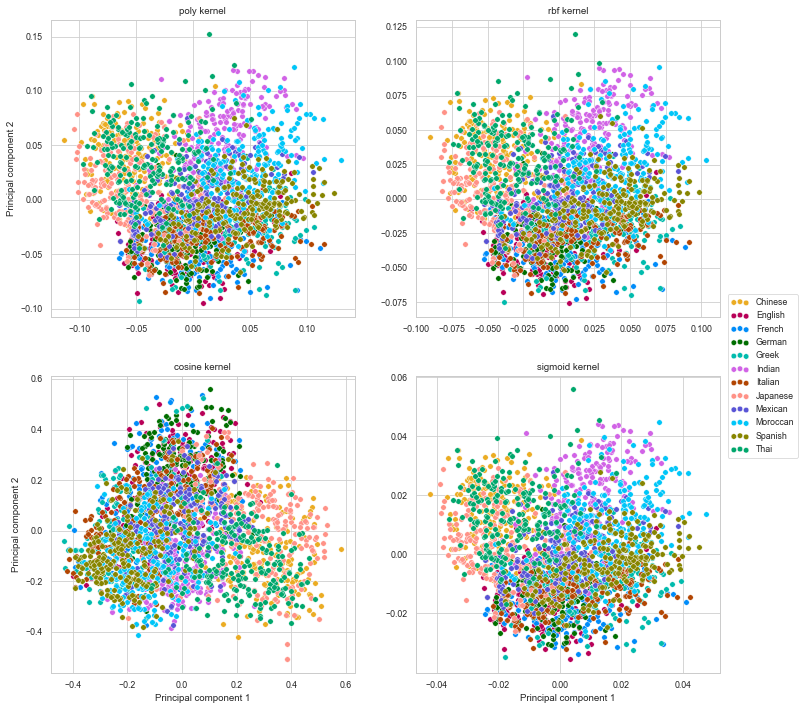

In [40]:
## Kernel PCA

kernels = ['poly', 'rbf', 'cosine', 'sigmoid']
fig, ax = plt.subplots(2,2,figsize=(12,12));

for ii, kernel in enumerate(kernels):
    X_kpca_2d = KernelPCA(n_components=2, kernel=kernel,random_state=10).fit_transform(X_train)
    cur_ax = ax[ii//2, ii%2]
    scatter_2d_label(X_kpca_2d, y_train_labels, ax=cur_ax,alpha=1,s=30)
    cur_ax.set(title='{} kernel'.format(kernel))
    cur_ax.legend().set_visible(False)

ax[0, 0].set_ylabel('Principal component 2')
ax[1, 0].set_ylabel('Principal component 2')

ax[1, 0].set_xlabel('Principal component 1')
ax[1, 1].set_xlabel('Principal component 1')

plt.legend(loc='center left', bbox_to_anchor=[1.01, 1.], scatterpoints=3);
# plt.savefig("./Figures/Kernel_PCA.png", dpi=500) ## Save the figure produced

In [41]:
##----------Variance Explained
## this takes a while. To rerun change the flag (for flags the whole cell won't run so only include the loop)
flag = True
if flag:
    pca_var = []
    for i in range(1,X_train.shape[1]-20): # the last 30 variance explained scores are all 1 so I explude them for a bit faster runtime
        pca_t = PCA(n_components=i, random_state=10).fit(X_train)
        pca_var.append(pca_t.explained_variance_ratio_.sum())


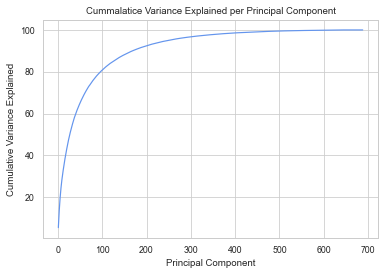

In [42]:
# plot the cumulative variance explained
x_ax = np.linspace(1,X_train.shape[1]-21,X_train.shape[1]-21) # PC scores
pca_var_dict = {'Cumulative Variance Explained': [i * 100 for i in pca_var], # variance explained * 100 to make it percent
                    'Principal Component': x_ax}
pca_var_df = pd.DataFrame(pca_var_dict, columns = ['Cumulative Variance Explained', 'Principal Component'])
ax = sns.lineplot(data=pca_var_df, x="Principal Component", y="Cumulative Variance Explained", color='cornflowerblue')
tt = ax.set(title="Cummalatice Variance Explained per Principal Component")

# ax.figure.savefig("./Figures/PCA_var_explained.png", dpi=500,bbox_inches='tight') ## Save the figure produced

In [43]:
# find X_embedded that retains more than 99% variance explained
pca_var = np.asarray(pca_var)
min_pcs = np.asarray(np.where(pca_var>0.99)).min()
X_embedded_pca = PCA(n_components=min_pcs, svd_solver='full', random_state=10).fit(X_train) # optimal PCA embedded vect

In [44]:
## variance explained based on optimum number from above
print('Explained variance: %.4f' % X_embedded_pca.explained_variance_ratio_.sum()) 

Explained variance: 0.9901


In [45]:
## - Individual variance contributions (uncomment to run, but creates clutter)
# print('Individual variance contributions:')
# for j in range(min_pcs):
#     print(X_embedded_pca.explained_variance_ratio_[j])

In [46]:
## - variance explained for normal PCA with 400 components (can remove)
train_pca = PCA(n_components=400).fit(X_train) # we can chain the instantiation and the fitting
train_pc_scores = train_pca.transform(X_train) # compute scores
val_pc_scores = train_pca.transform(X_val) # compute scores
test_pc_scores = train_pca.transform(X_test) # compute scores
print('Explained variance: %.4f' % train_pca.explained_variance_ratio_.sum()) ## variance explained?

Explained variance: 0.9858


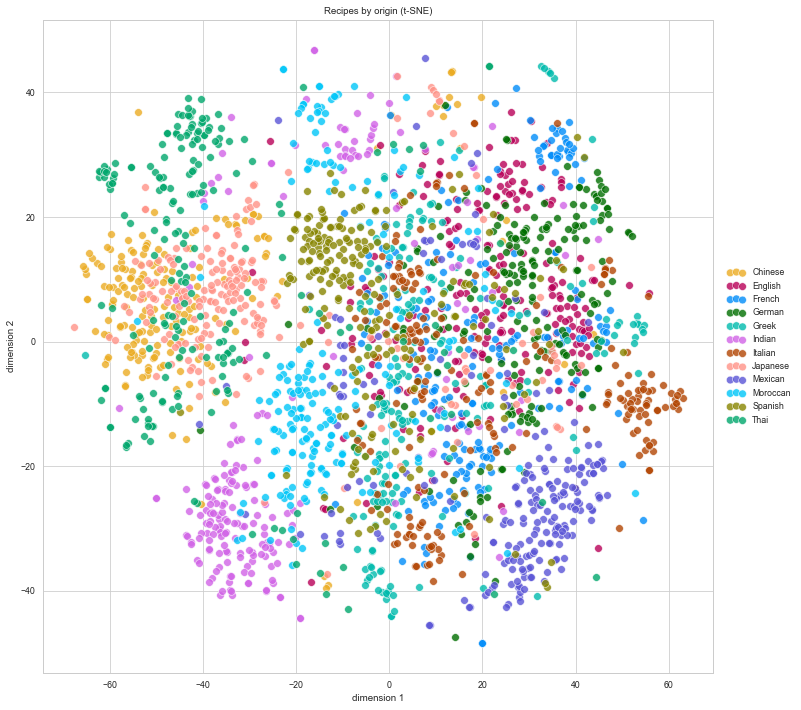

In [47]:
## tSNE
## create low dimensional representasion with TSNE
X_embedded_tSNE_train = TSNE(n_components=2,perplexity=30,n_iter=2000,init='pca', random_state=10).fit_transform(X_train)

## ---- Plot the figure
fig, ax = plt.subplots(figsize=(12,12))
scatter_2d_label(X_embedded_tSNE_train,y_train_labels,alpha=.8,ax=ax,s=60)
ax.set_xlabel('dimension 1')
ax.set_ylabel('dimension 2')
title = ax.set(title='Recipes by origin (t-SNE)')
# ax.figure.savefig("./Figures/PCA_tSNE.png", dpi=500) ## Save the figure produced

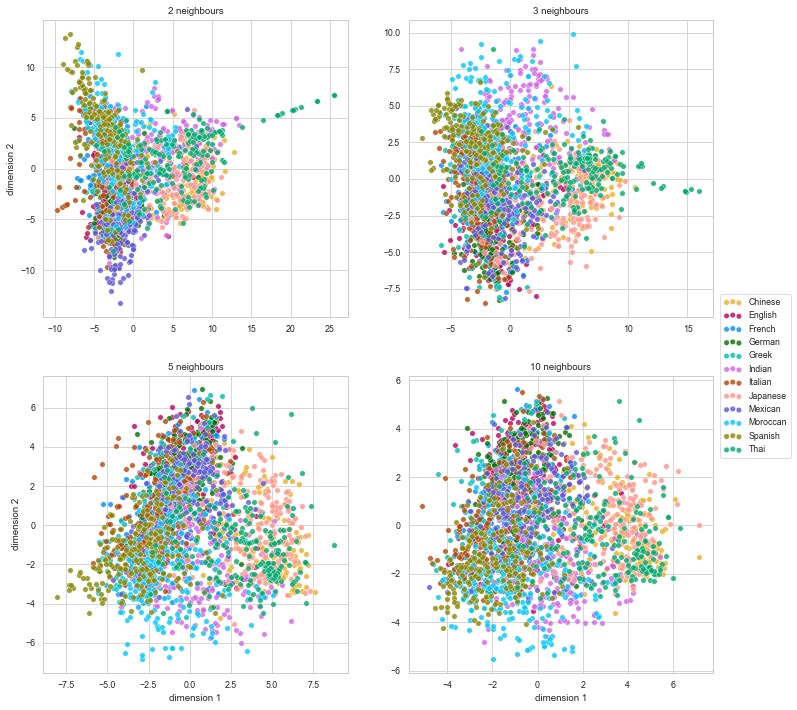

In [48]:
## ISOMAP
n_neighbours_arr = [2, 3, 5, 10]
fig, ax = plt.subplots(2,2,figsize=(12,12))

for ii, n_neighbours in enumerate(n_neighbours_arr):
    ismp = Isomap(n_components=2, n_neighbors=n_neighbours)
    X_ismp_2d = ismp.fit_transform(X_train)
    
    cur_ax = ax[ii//2, ii%2]
    scatter_2d_label(X_ismp_2d, y_train_labels, ax=cur_ax,alpha=.8,s=30)
    cur_ax.set(title='{} neighbours'.format(n_neighbours))
    cur_ax.legend().set_visible(False)
 
ax[0, 0].set_ylabel('dimension 2')
ax[1, 0].set_ylabel('dimension 2')

ax[1, 0].set_xlabel('dimension 1')
ax[1, 1].set_xlabel('dimension 1')

plt.legend(loc='center left', bbox_to_anchor=[1.01, 1.], scatterpoints=3);
# plt.savefig("./Figures/ISOMAP_PCA.png", dpi=500) ## Save the figure produced

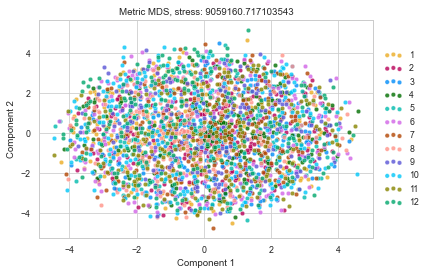

In [49]:
## Metric MDS based on Euclidean distances
mds = MDS(n_components=2, n_jobs=-1, random_state=10, max_iter=100)
X_mds_2d = mds.fit_transform(X_train)

scatter_2d_label(X_mds_2d, y_train,alpha=.8,s=20)
plt.title('Metric MDS, stress: {}'.format(mds.stress_))
plt.xlabel('Component 1')
plt.ylabel('Component 2');
# plt.savefig("./Figures/Metric_MDS_euclid dist.png", dpi=500,bbox_inches='tight') ## Save the figure produced

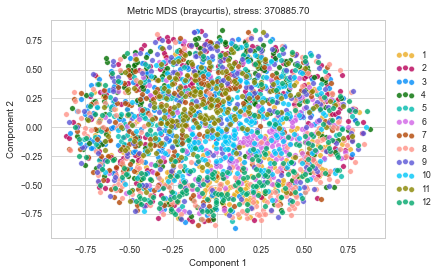

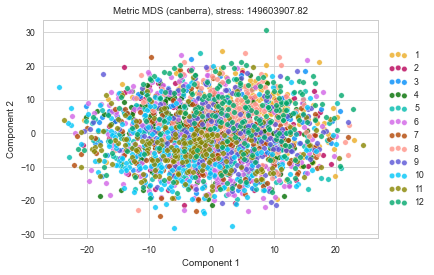

In [50]:
## Metric MDS based on custom distances
my_metrics = ['braycurtis', 'canberra']
for metric in my_metrics:
    delta = pairwise_distances(X=X_train, metric=metric)
    mds = MDS(n_components=2, dissimilarity='precomputed', n_jobs=-1, max_iter=100)
    X_mds_2d = mds.fit_transform(delta)
    scatter_2d_label(X_mds_2d, y_train,alpha=.8,s=30)
    plt.title('Metric MDS ({0}), stress: {1:.2f}'.format(metric, mds.stress_))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2');
    ## Save the figure produced
#     plt.savefig("./Figures/Metric_MDS_{}.png".format(metric), dpi=500,bbox_inches='tight') 
    


# Models

Scikit-learn implements the `DummyClassifier` class which offers "dummy classifiers" that implement simple classification rules ([documentation](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)). You can use the `strategy` parameter to choose among different baseline strategies. 

Two kinds of dummy classifiers: one that always predicts the most frequent label in the training set, and one that guesses the label randomly whilst respecting possible class imbalances in the training data.

In [51]:
## --------- Baselines
def dummy_pipe(X_train, y_train, dummy_strategy,random_state):
    
    # dummy classifier
    dclf = DummyClassifier(strategy=dummy_strategy, random_state=random_state)
    
    # train
    dclf.fit(X_train, y_train)

    return dclf

pipe_mf = dummy_pipe(X_train, y_train, 'most_frequent',random_state=10)
val_score_mf = pipe_mf.score(X_val, y_val)

# Note: since labels are guessed randomly, different runs give different results
pipe_strat = dummy_pipe(X_train, y_train, 'stratified',random_state=10)  
val_score_strat = pipe_strat.score(X_val, y_val)

print("Classification accuracy on the validation set:")
print("'Most-frequent' dummy classifier: {0:.3f}".format(val_score_mf))
print("'Stratified' dummy classifier: {0:.3f}".format(val_score_strat))

Classification accuracy on the validation set:
'Most-frequent' dummy classifier: 0.077
'Stratified' dummy classifier: 0.092


In [52]:
## Logistic Regression & Naive Bayes

names = ["Gaussian Naive Bayes", "Logistic Regression"]
classifiers = [
    GaussianNB(),
    LogisticRegression(max_iter=1000)]

# Training 
ca_train_score = {}  # Classification accuracy
ce_train_score = {}  # Cross-entropy

# Validation
ca_val_score = {} 
ce_val_score = {}

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    
    ca_train_score[name] = clf.score(X_train, y_train)
    ce_train_score[name] = log_loss(y_train, clf.predict_proba(X_train))
    
    ca_val_score[name] = clf.score(X_val, y_val)
    ce_val_score[name] = log_loss(y_val, clf.predict_proba(X_val))

In [53]:
print('Classification performance on validation and training set: \n')
print("{0:<20s}   {1:-^25s}   {2:-^21s}".format('','Validation', 'Training'))
print("{0:<20s}{1:>13s}{2:>13s}{3:>13s}{4:>13s}".format(
    'Method', 'Accuracy\u2191', 'Log-loss\u2193',
    'Accuracy\u2191', 'Log-loss\u2193'))
print("-"*(20+4*13))
for clf in names:
    print ("{method:<20s}{val_accuracy:>13.3f}{val_logloss:>13.3f}{train_accuracy:>13.3f}{train_logloss:>13.3f}".format(
        method=clf, val_accuracy=ca_val_score[clf], val_logloss=ce_val_score[clf],
        train_accuracy=ca_train_score[clf], train_logloss=ce_train_score[clf]))

Classification performance on validation and training set: 

                       -------Validation--------   ------Training-------
Method                  Accuracy↑    Log-loss↓    Accuracy↑    Log-loss↓
------------------------------------------------------------------------
Gaussian Naive Bayes        0.556       15.148        0.709        9.600
Logistic Regression         0.767        0.729        0.916        0.365


<span style="color:orange"><ins>The following results are similar to the above so i feel they are redundant, but i have included them anyway in case we want the bellow which are more detailed. I would suggest to  keep only one of the two</ins></span>. Due to higher detail we can argue about the performance per cuisine and how the PCA tSNE might help on that front.

In [54]:
log_reg = LogisticRegression(random_state=10,max_iter=1000).fit(X_train, y_train)

#--- training performance 
predict_logreg_train = log_reg.predict(X_train)
train_score = log_reg.score(X_train, y_train)

#--- validation performance
predict_logreg_val = log_reg.predict(X_val)
val_score = log_reg.score(X_val, y_val)

print("Main classification metrics:\n")
print(classification_report(y_train, predict_logreg_train, target_names=cuisines))
print("Mean accuracy on train data and labels: {:.3f}\n\n".format(train_score))

Main classification metrics:

              precision    recall  f1-score   support

     Chinese       0.91      0.91      0.91       193
     English       0.84      0.85      0.85       217
      French       0.83      0.82      0.83       204
      German       0.88      0.89      0.89       206
       Greek       0.93      0.93      0.93       199
      Indian       0.96      0.98      0.97       221
     Italian       0.90      0.92      0.91       215
    Japanese       0.92      0.91      0.92       215
     Mexican       0.96      0.98      0.97       222
    Moroccan       0.96      0.97      0.97       209
     Spanish       0.91      0.86      0.88       224
        Thai       0.97      0.96      0.97       216

    accuracy                           0.92      2541
   macro avg       0.92      0.92      0.92      2541
weighted avg       0.92      0.92      0.92      2541

Mean accuracy on train data and labels: 0.916




In [55]:
print("Main classification metrics:\n")
print(classification_report(y_val, predict_logreg_val, target_names=cuisines))
print("Mean accuracy on validation data and labels: {:.3f}".format(val_score))

Main classification metrics:

              precision    recall  f1-score   support

     Chinese       0.84      0.78      0.81        87
     English       0.57      0.55      0.56        71
      French       0.57      0.61      0.59        75
      German       0.75      0.85      0.80        65
       Greek       0.80      0.83      0.81        76
      Indian       0.83      0.86      0.84        56
     Italian       0.75      0.75      0.75        69
    Japanese       0.71      0.78      0.74        76
     Mexican       0.89      0.90      0.89        70
    Moroccan       0.98      0.74      0.84        69
     Spanish       0.70      0.77      0.74        65
        Thai       0.93      0.82      0.87        68

    accuracy                           0.77       847
   macro avg       0.78      0.77      0.77       847
weighted avg       0.78      0.77      0.77       847

Mean accuracy on validation data and labels: 0.767


### Search for hyperparameters

In [56]:
## Hyperparameter tuning for Logistic Regression
hyp_reg = np.arange(0.8, 2.5, 0.1)
c_val_score = []
c_train_score = []
# splitting it in two just for readability
for c in range(0, len(hyp_reg), 1):
    # splitting it in two just for readability
    reg_helper = LogisticRegression(random_state=10, C=hyp_reg[c], max_iter=1000)
    fit_hyp = reg_helper.fit(X_train, y_train)
    c_train_score.append(fit_hyp.score(X_train, y_train))
    c_val_score.append(fit_hyp.score(X_val, y_val))
    
print('Classification performance on validation set: \n')
print("{0:<20s}   {1:-^13s}   {2:-^13s}".format('','Validation', 'Training'))
print("{0:<20s} {1:>13s} {2:>13s}".format(
    'Hyperparameter value', 'Accuracy\u2191',
    'Accuracy\u2191'))
print("-"*(20+4*13))
for c in range(0, len(hyp_reg), 1):
    print ("{Hyperparameter_value:<20f}{val_accuracy:>13.3f}{train_accuracy:>13.3f}".format(
        Hyperparameter_value=hyp_reg[c], 
        val_accuracy=c_val_score[c],
        train_accuracy=c_train_score[c])) 

best_hyper = hyp_reg[c_val_score.index(max(c_val_score))]
print("Hyperparameter with the best score on the validation test: {}".format(best_hyper))

Classification performance on validation set: 

                       -Validation--   --Training---
Hyperparameter value     Accuracy↑     Accuracy↑
------------------------------------------------------------------------
0.800000                    0.770        0.908
0.900000                    0.769        0.912
1.000000                    0.767        0.916
1.100000                    0.771        0.920
1.200000                    0.770        0.924
1.300000                    0.769        0.928
1.400000                    0.770        0.932
1.500000                    0.771        0.935
1.600000                    0.770        0.937
1.700000                    0.770        0.939
1.800000                    0.769        0.941
1.900000                    0.766        0.943
2.000000                    0.766        0.945
2.100000                    0.764        0.946
2.200000                    0.762        0.946
2.300000                    0.759        0.947
2.400000                 

In [57]:
#--- fit logistic regression again on training plus validation data
#use _full data for this
log_reg_full = LogisticRegression(random_state=10, C=best_hyper, max_iter=1000).fit(X_train_full, y_train_full.squeeze())

#--- testing performance
predict_logreg_full = log_reg.predict(X_test)
test_score = log_reg_full.score(X_test, y_test)
print("Main classification metrics:\n")
print(classification_report(y_test, predict_logreg_full, target_names=cuisines))
print("Mean accuracy on test data and labels: {:.3f}".format(test_score))

Main classification metrics:

              precision    recall  f1-score   support

     Chinese       0.83      0.73      0.77        73
     English       0.58      0.63      0.60        65
      French       0.68      0.70      0.69        74
      German       0.79      0.80      0.80        82
       Greek       0.76      0.79      0.77        78
      Indian       0.86      0.82      0.84        76
     Italian       0.71      0.80      0.75        69
    Japanese       0.70      0.76      0.73        62
     Mexican       0.92      0.92      0.92        61
    Moroccan       0.89      0.83      0.86        75
     Spanish       0.67      0.61      0.64        64
        Thai       0.88      0.84      0.86        69

    accuracy                           0.77       848
   macro avg       0.77      0.77      0.77       848
weighted avg       0.77      0.77      0.77       848

Mean accuracy on test data and labels: 0.776


In [58]:
## Logistic Regression & Naive Bayes after PCA

names = ["Gaussian Naive Bayes", "Logistic Regression"]
classifiers = [
    GaussianNB(),
    LogisticRegression(max_iter=1000)]

# Training 
ca_train_score = {}  # Classification accuracy
ce_train_score = {}  # Cross-entropy

# Validation
ca_val_score = {} 
ce_val_score = {}

for name, clf in zip(names, classifiers):
    clf.fit(train_pc_scores, y_train)
    
    ca_train_score[name] = clf.score(train_pc_scores, y_train)
    ce_train_score[name] = log_loss(y_train, clf.predict_proba(train_pc_scores))
    
    ca_val_score[name] = clf.score(val_pc_scores, y_val)
    ce_val_score[name] = log_loss(y_val, clf.predict_proba(val_pc_scores))

print('Classification performance on validation and training set: \n')
print("{0:<20s}   {1:-^25s}   {2:-^21s}".format('','Validation', 'Training'))
print("{0:<20s}{1:>13s}{2:>13s}{3:>13s}{4:>13s}".format(
    'Method', 'Accuracy\u2191', 'Log-loss\u2193',
    'Accuracy\u2191', 'Log-loss\u2193'))
print("-"*(20+4*13))
for clf in names:
    print ("{method:<20s}{val_accuracy:>13.3f}{val_logloss:>13.3f}{train_accuracy:>13.3f}{train_logloss:>13.3f}".format(
        method=clf, val_accuracy=ca_val_score[clf], val_logloss=ce_val_score[clf],
        train_accuracy=ca_train_score[clf], train_logloss=ce_train_score[clf]))

Classification performance on validation and training set: 

                       -------Validation--------   ------Training-------
Method                  Accuracy↑    Log-loss↓    Accuracy↑    Log-loss↓
------------------------------------------------------------------------
Gaussian Naive Bayes        0.521       10.900        0.594        7.767
Logistic Regression         0.763        0.737        0.906        0.382


In [59]:
## validation set tSNE
X_embedded_tSNE_val = TSNE(n_components=2,perplexity=30,n_iter=2000,init='pca', random_state=10).fit_transform(X_val)

In [60]:
## Logistic Regression & Naive Bayes after PCA tSNE

names = ["Gaussian Naive Bayes", "Logistic Regression"]
classifiers = [
    GaussianNB(),
    LogisticRegression(max_iter=1000)]

# Training 
ca_train_score = {}  # Classification accuracy
ce_train_score = {}  # Cross-entropy

# Validation
ca_val_score = {} 
ce_val_score = {}

for name, clf in zip(names, classifiers):
    clf.fit(X_embedded_tSNE_train, y_train)
    
    ca_train_score[name] = clf.score(X_embedded_tSNE_train, y_train)
    ce_train_score[name] = log_loss(y_train, clf.predict_proba(X_embedded_tSNE_train))
    
    ca_val_score[name] = clf.score(X_embedded_tSNE_val, y_val)
    ce_val_score[name] = log_loss(y_val, clf.predict_proba(X_embedded_tSNE_val))

print('Classification performance on validation and training set: \n')
print("{0:<20s}   {1:-^25s}   {2:-^21s}".format('','Validation', 'Training'))
print("{0:<20s}{1:>13s}{2:>13s}{3:>13s}{4:>13s}".format(
    'Method', 'Accuracy\u2191', 'Log-loss\u2193',
    'Accuracy\u2191', 'Log-loss\u2193'))
print("-"*(20+4*13))
for clf in names:
    print ("{method:<20s}{val_accuracy:>13.3f}{val_logloss:>13.3f}{train_accuracy:>13.3f}{train_logloss:>13.3f}".format(
        method=clf, val_accuracy=ca_val_score[clf], val_logloss=ce_val_score[clf],
        train_accuracy=ca_train_score[clf], train_logloss=ce_train_score[clf]))

Classification performance on validation and training set: 

                       -------Validation--------   ------Training-------
Method                  Accuracy↑    Log-loss↓    Accuracy↑    Log-loss↓
------------------------------------------------------------------------
Gaussian Naive Bayes        0.100        2.691        0.432        1.804
Logistic Regression         0.148        2.539        0.356        1.905


In [61]:
## Logistic Regression DR


## Naive Bayes DR


## Other 1


## Other 2


## Other 3

In [62]:
#------------VALIDATION-------------------------------

## BEST MODEL Hyperparameter tuning

## Final Model



In [63]:
#------------TEST SET PREDICTIONS---------------------

## Accuracy scores

## MISC

